# Выбор локации для скважины

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*



## Загрузка и подготовка данных

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
import itertools
from scipy import stats

Прочитаем датасеты и изучим данные таблиц. 

In [49]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Шаги для выбора локации для скважины:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Создадим функцию, которая будет выводить запрашиваемую информацию о датасете. И посмотрим на данные: есть ли там пропущенные значения, ошибки или неподходящий тип данных.

In [50]:
def display_info(isFrame, **kwargs):
    if isFrame:
        out_func = display
    else: 
        out_func = print
        
    for frame_name, args in kwargs.items():
        for info_string,element in args.items():
            if not info_string:
                out_func(element)
            else:
                out_func(info_string,element)
        print()

In [51]:
display_info(True,
             data_0 = {'Первый регион':data_0.head()},
             data_1 = {'Второй регион':data_1.head()},
             data_2 = {'Третий регион':data_2.head()})

'Первый регион'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'Второй регион'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'Третий регион'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Видим, что признаки точек имеют отрицательные значения во всех трех регионах. В описании данных было отмечено, что неважно, что означают эти признаки, главное их значимость. Столбец с объемом запасов в скважине имеет большие разбросы даже по первым пяти объектам. Посмотрим на тип данных.

In [52]:
display_info(True,
             data_0 = {'':data_0.info()},
             data_1 = {'':data_1.info()},
             data_2 = {'':data_2.info()})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8

None

None

None

В каждом датасете по 10000 объектов, нужно их будет проверить на наличие дубликатов. Типы данных в каждом датасете соответствуют параметрам для машинного обучения - три признака и объем запасов в скважине имеюют тип данных float64, и только у id строчной тип данных, но если дубликатов не будет обнаружено, то этот столбец мы сможем легко удалить, так как он не несет никакой значимости для машинного обучения. Пропущенных значений нигде не обнаружено. Далее посмотрим еще внимательнее на значения датасетов. 

In [53]:
display_info(True,
             data_0 = {'Первый регион':data_0.describe()},
             data_1 = {'Второй регион':data_1.describe()},
             data_2 = {'Третий регион':data_2.describe()})

'Первый регион'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Второй регион'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Третий регион'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В первом регионе средний объем запасов в скважине - 92.5 тыс. баррелей.
Во втором регионе - 68.8 тыс. баррелей.
В третьем регионе - 95 тыс. баррелей.

Теперь же посмотрим на наличчие дубликатов.

In [54]:
display_info(False,
             data_0 = {'Количество дубликатов в первом датасете:':data_0.duplicated().sum()},
             data_1 = {'Количество дубликатов во втором датасете:':data_1.duplicated().sum()},
             data_2 = {'Количество дубликатов в третьем датасете:':data_2.duplicated().sum()})

Количество дубликатов в первом датасете: 0

Количество дубликатов во втором датасете: 0

Количество дубликатов в третьем датасете: 0



Создадим функцию по подсчету нулевых значений в датасетах и их процентной доле. Посмотрим их количество в столбце 'product', затем в каких строчках эти нулевые значения.

In [55]:
def check_zeros(df, target_name):
    zeros = df[df[target_name] == 0][target_name].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Процент нулевых значений -', percent)

In [56]:
check_zeros(data_0, 'product')
check_zeros(data_1, 'product')
check_zeros(data_2, 'product')

Количество нулевых значений - 1
Процент нулевых значений - 1e-05
Количество нулевых значений - 8235
Процент нулевых значений - 0.08235
Количество нулевых значений - 1
Процент нулевых значений - 1e-05


In [57]:
data_0[data_0['product'] == 0]

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


In [58]:
data_1[data_1['product'] == 0]

,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...,...
99936,YrRU8,5.085749,-3.980305,0.005063,0.0
99948,Jbnur,8.277805,-9.178818,0.003275,0.0
99956,aV1cJ,13.343983,-1.290200,0.005980,0.0
99961,Zjbn2,13.854163,-11.528089,-0.005556,0.0


In [59]:
data_2[data_2['product'] == 0]

,id,f0,f1,f2,product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


Видим, что во втором регионе очень много нулевых значений. Данные либо потеряны, либо скважины изначально не были изучены. Мы ничего делать с этими значениями не будем, так как не владеем достаточным количеством информации.

Посмотрим визуально на объем запасов нефти. 

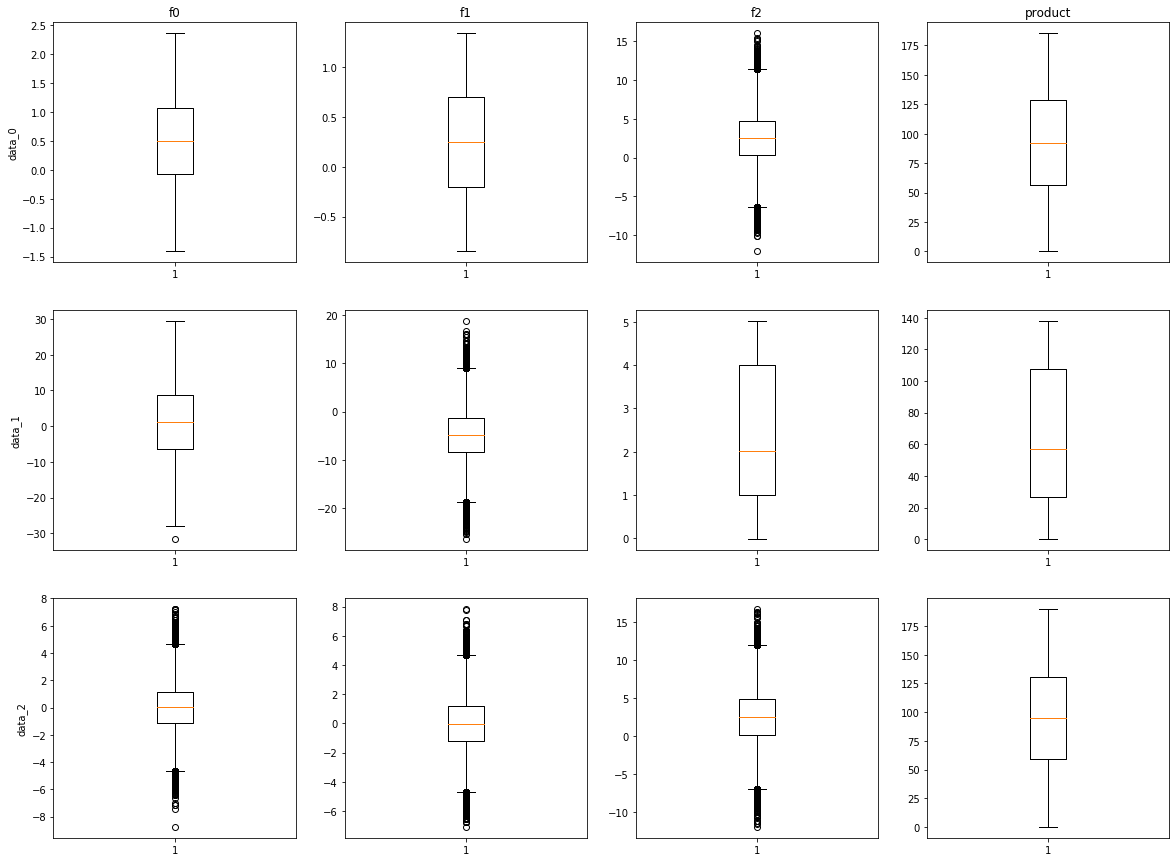

In [60]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["data_0","data_1","data_2"]
num_columns = data_0.columns[1:]
num_columns_with_columns = zip(data_0.columns[1:],range(4))
all_frames_with_rows = zip([data_0,data_1,data_2],range(3))

for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])

for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])

for column in range(4):
    ax[0][column].set_title(num_columns[column])

В первом регионе очень большой разброс значений у третьего признака.  
Второй регион имеет выбросы во втором признаке.  
Третий регион богат на выбросы по всем трем признакам.

Изучим корреляцию между признаками.

In [61]:
display_info(True,
             data_0 = {'Первый регион':data_0.corr()},
             data_1 = {'Второй регион':data_1.corr()},
             data_2 = {'Третий регион':data_2.corr()})

'Первый регион'

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


'Второй регион'

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


'Третий регион'

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Заметим, что в первом регионе признаки f0 и f1 отрицательно коррелируют относительно друг друга и f2 слабо положительно коррелирует с целевым признаком.   
Во втором регионе очень сильно коррелирует целевой признак и f2.   
В третьем регионе так же есть коррелирующие признаки, такие как f2 и product.

Так как в данных нет пропущенных значений, то мы можем удалить столбцы с id, ведь они не несут никакой важной значимости для машинного обучения. 

In [62]:
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)

#### Выводы 

По результатам подготовки данных - 

Пропуски не обнаружены в датасетах,    
Типы данных соответствуют параметрам для машинного обучения,   
Названия столбцов верны,   
Дубликаты в данных не обнаружены,    
Объем запасов везде положительный,    
Коррелирующие признаки изучены.


## Обучение и проверка модели

Выделим целевой признак и разобъем датасет на обучающую и валидационную выборки в соотношении 75:25.
Проверим качество модели линейной регрессии с текущим значением признаков и с масштабируемыми. Проверим эту гипотезу на нулевом датасете, то есть на первом регионе. 

In [63]:
def test_split(df, target):
    features = df.drop([target] , axis=1)
    target = df[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    return features_train, features_valid, target_train, target_valid

In [64]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split(data_0, 'product')
features_train_0.head()

,f0,f1,f2
78638,0.602333,-0.445623,3.165303
67323,-0.984306,0.046746,0.400594
25303,0.085069,0.050226,-0.374703
80751,0.174317,0.011649,4.180446
28950,0.372650,1.031981,2.904160


Теперь создадим функцию дла масштабирования.

In [65]:
def test_split_scaled(df, numeric, target):
    data_s = df.copy()

    features_s = data_s.drop([target] , axis=1)
    target_s = data_s[target]

    features_train_s, features_valid_s, target_train_s, target_valid_s = train_test_split(
        features_s, target_s, test_size=0.25, random_state=5062020)

    scaler = StandardScaler()
    scaler.fit(features_train_s[numeric])
    features_train_s[numeric] = scaler.transform(features_train_s[numeric])
    features_valid_s[numeric] = scaler.transform(features_valid_s[numeric])

    return features_train_s, features_valid_s, target_train_s, target_valid_s

Сравним качество данных без изменений с масштабированием.

In [66]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)



features_train_0s, features_valid_0s, target_train_0s, target_valid_0s = test_split_scaled(
                                                                        data_0, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_0s, target_train_0s)
predicted_target_0s = model.predict(features_valid_0s)
print('RMSE -', mean_squared_error(target_valid_0s, predicted_target_0s)**0.5)

RMSE - 37.401957199217094
RMSE - 37.401957199217094


In [67]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split(data_1, 'product')
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE -', mean_squared_error(target_valid_1, predicted_target_1)**0.5)



features_train_1s, features_valid_1s, target_train_1s, target_valid_1s = test_split_scaled(
                                                                        data_1, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_1s, target_train_1s)
predicted_target_1s = model.predict(features_valid_1s)
print('RMSE -', mean_squared_error(target_valid_1s, predicted_target_1s)**0.5)

RMSE - 0.8874258342572853
RMSE - 0.887425834257285


In [68]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split(data_2, 'product')
model.fit(features_train_2, target_train_2)
predicted_target_2 = model.predict(features_valid_2)
print('RMSE -', mean_squared_error(target_valid_2, predicted_target_2)**0.5)



features_train_2s, features_valid_2s, target_train_2s, target_valid_2s = test_split_scaled(
                                                                        data_2, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_2s, target_train_2s)
predicted_target_2s = model.predict(features_valid_2s)
print('RMSE -', mean_squared_error(target_valid_2s, predicted_target_2s)**0.5)

RMSE - 40.18553497171235
RMSE - 40.18553497171235


Данные во всех трех регионах не изменились, соответственно масштабирование не требуется. Посмотрим как поведет себя среднеквадратическая ошибка при других гиперпараметрах модели.

In [69]:
model = LinearRegression(normalize=True)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 37.401957199217094


In [70]:
model = LinearRegression(fit_intercept=False)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 60.749819777751355


Изменение стандартных значений гиперпараметров не улучшило модель. Попробуем сделать вывод предсказанного запаса с реальным и выведем RMSE.

In [71]:
model = LinearRegression()

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [72]:
data_0_predicted, data_0_rmse, data_0_predicted_mean, data_0_predicted_sum = oil_predict(data_0, 'product')
display(data_0_predicted.head())
print('RMSE -', data_0_rmse)
print('Средний запас сырья -', data_0_predicted_mean)

,real_product,predicted_product
87351,145.407098,110.644337
52805,131.589165,76.793446
6583,101.596316,103.711077
34986,8.123407,53.135348
8253,169.834019,151.656408


RMSE - 37.401957199217094
Средний запас сырья - 92.52620585803335


In [73]:
data_1_predicted, data_1_rmse, data_1_predicted_mean, data_1_predicted_sum = oil_predict(data_1, 'product')
display(data_1_predicted.head())
print('RMSE -', data_1_rmse)
print('Средний запас сырья -', data_1_predicted_mean)

,real_product,predicted_product
87351,53.906522,54.336477
52805,3.179103,3.756436
6583,30.132364,31.266991
34986,26.953261,26.692436
8253,30.132364,31.128898


RMSE - 0.8874258342572853
Средний запас сырья - 68.27820207556354


In [74]:
data_2_predicted, data_2_rmse, data_2_predicted_mean, data_2_predicted_sum = oil_predict(data_2, 'product')
display(data_2_predicted.head())
print('RMSE -', data_2_rmse)
print('Средний запас сырья -', data_2_predicted_mean)

,real_product,predicted_product
87351,140.971569,62.929196
52805,125.190694,98.323840
6583,94.544056,79.920918
34986,107.208380,104.706020
8253,173.924418,114.066050


RMSE - 40.18553497171235
Средний запас сырья - 94.94294307153748


По результатам анализа, первый регион богат на запасы сырья, в то время как второй регион имеет наименьшее значение корня из средней квадратичной ошибки, что может говорить о сильном переобучении модели или, наоорот, как о хорошей модели. 

In [75]:
print('Суммарный предсказанный запас в 1 регионе -', data_0_predicted_sum)
print('Суммарный реальный запас в 1 регионе -', data_0_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас во 2 регионе -', data_1_predicted_sum)
print('Суммарный реальный запас во 2 регионе -', data_1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в 3 регионе -', data_2_predicted_sum)
print('Суммарный реальный запас в 3 регионе -', data_2_predicted['real_product'].sum())

Суммарный предсказанный запас в 1 регионе - 2313155.146450834
Суммарный реальный запас в 1 регионе - 2313395.805667925

Суммарный предсказанный запас во 2 регионе - 1706955.0518890887
Суммарный реальный запас во 2 регионе - 1706710.3444370048

Суммарный предсказанный запас в 3 регионе - 2373573.576788437
Суммарный реальный запас в 3 регионе - 2378821.7815969232


#### Выводы 

Масштабирование нам не понадобилось.

Данные предсказаний о количестве нефти по сумме примерно совпадают по сумме с предсказанными значениями. Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.88), далее в первом и третьем соотвественно.

Помним, что во втором регионе было очень много нулевых значений, то есть данные были либо утеряны, либо не изучены изначально. Это могло сказаться на модели и на ее переобучении. 

Далее изучим все регионы на риски и прибыль,и выберем самый прибыльные регион с наименьшим процентом риска. 

## Подготовка к расчёту прибыли

Создадим переменные, в которых укажем всю необходимую информацию для экономических рассчетов. 

In [98]:
BUDGET = 10_000_000_000
CHOSEN_POINTS = 500
BEST_POINTS = 200
PRICE_PER_BARREL = 450000

Посчитаем разработку сырья на 200 месторождениях без убытка. Затем найдем средний объем запаса нефти на скважину.

In [99]:
average_profit_per_point = BUDGET / BEST_POINTS
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / PRICE_PER_BARREL
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. баррелей')

average_barrels = BUDGET / PRICE_PER_BARREL
print('Средний объем нефти на регион -',average_barrels, 'тыс. баррелей')

Средняя прибыль на лучшую точку - 50000000.0 тыс.руб.
Средний объем нефти на точку - 111.11111111111111 тыс. баррелей
Средний объем нефти на регион - 22222.222222222223 тыс. баррелей


In [100]:
print('Средний запас фактичекой нефти на скважину в регионе 1 - ', data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2 - ', data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3 - ', data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 -  92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2 -  68.82500000000002
Средний запас фактичекой нефти на скважину в регионе 3 -  95.00000000000004


Второй регион все также выделяется и показывает наименьший средний запас нефти на скважину - 68 тыс. баррелей.   
Создадим функцию для расчета прибыли на 500 разведанных точек.

In [114]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return ((PRICE_PER_BARREL * selected.sum()) - BUDGET)  

Создадим функцию для построения гистограмм и посмотрим эти распределения по регионам.

In [102]:
def oil_hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

Ниже преддставлены распределения предсказанных значений.

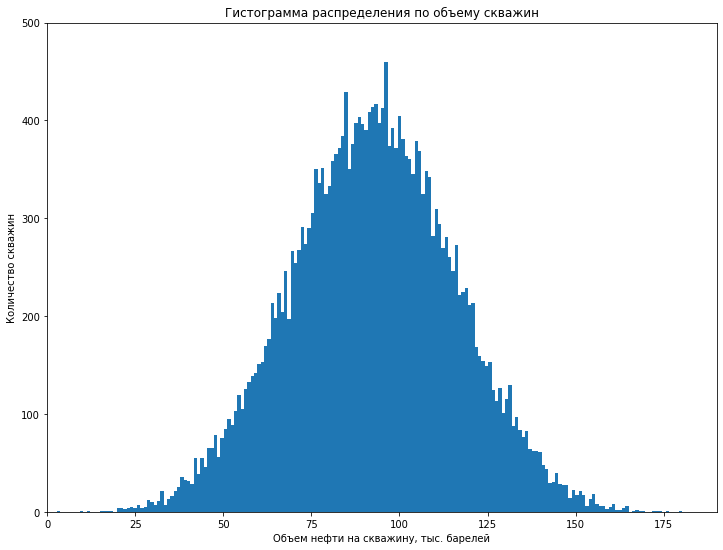

In [103]:
oil_hist(data_0_predicted['predicted_product'], 200, 190, 500)

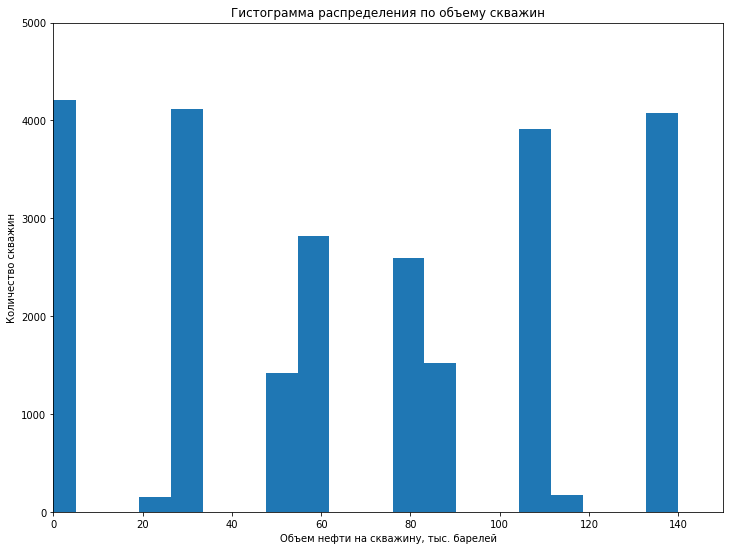

In [104]:
oil_hist(data_1_predicted['predicted_product'], 20, 150, 5000)

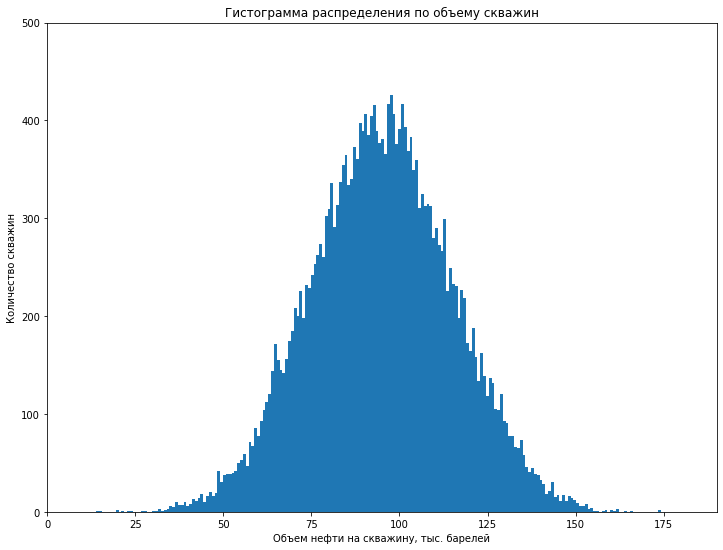

In [105]:
oil_hist(data_2_predicted['predicted_product'], 200, 190, 500)

#### Выводы 

Были подготовлены все необходимые переменные для рассчетов средней оценки прибыли за скважину и среднего объема нефти на скважину. С помощью этих переменных мы написали функцию по расчету прибыли.

Анализ средних объемов на скважину для каждого региона получился следующий:

Изучены средние фактические запасы. Для первого и третьего регионов есть высокая вероятность окупить затраты, так как объем нефти намного больше, чем во втором регионе. Разброс значений вокруг среднего 92.5 и 95 свидетельствует о том, что существует достаточно много скважин, где запасы больше необходимого среднего.

Во втором регионе есть вероятность того, что выбранные скважины окажутся больше среднего объема нефти на точку (111), несмотря на то, что среднее значение запаса фактичекой нефти на скважину равно 68.  

## Расчёт прибыли и рисков 

Пишем функцию для рассчета прибыли и рисков, применяя технику Bootstrap с 1000 выборок. 
Также найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [134]:
state = np.random.RandomState(5062020)
def bootstrap_1000(target, probs):
    values=[]
    #lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=CHOSEN_POINTS)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target_sample, probs_sample, BEST_POINTS)
        #if profit < 0:
            #lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    #risk = lost / 1000
    risk = stats.percentileofscore(values, 0) / 100
    return average, lower, upper, risk

In [135]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(data_0_predicted['real_product'], 
                                                     data_0_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по первому региону.
Средняя прибыль по региону = 472119934.92 тыс.руб.
95% доверительный интервал от -45239375.62 до 991985585.30 тыс.руб.
Процент риска 3.90%


In [136]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(data_1_predicted['real_product'], 
                                                     data_1_predicted['predicted_product'])
print('Данные по второму региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по второму региону.
Средняя прибыль по региону = 462690411.56 тыс.руб.
95% доверительный интервал от 31089936.72 до 900786663.77 тыс.руб.
Процент риска 1.90%


In [137]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(data_2_predicted['real_product'], 
                                                     data_2_predicted['predicted_product'])
print('Данные по третьему региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по третьему региону.
Средняя прибыль по региону = 427165393.39 тыс.руб.
95% доверительный интервал от -133949760.97 до 953500752.49 тыс.руб.
Процент риска 6.30%


#### Выводы 

В результате исследования, мы отсеиваем первый и третий регионы, так как процент риска в них больше, чем во втором регионе. Методом исключения получается второй регион, где рисков намного меньше, несмотря на то, что данные в соответствующем датасете с самого начала не выглядели нормально распределенными, да еще и с большим количеством утерянных значений.

Также доверительный интервал показывает, что разработка скважин может окупиться, даже если выбор этих точек будет не совсем удачным.

Второй регион получился одним из лучших по показателям предсказывания, на нем и остановимся!